In [1]:
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR

In [2]:
data = scipy.io.loadmat("../data/ex3data1.mat")
raw_X = data['X']
raw_y = data['y']
raw_y[raw_y == 10] = 0

In [3]:
x_train, x_test, y_train, y_test = train_test_split(raw_X, raw_y, test_size=0.2, random_state=42)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64).flatten()
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64).flatten()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"{X.shape}")
    print(f"{y.shape} {y.dtype}")
    break

torch.Size([64, 400])
torch.Size([64]) torch.int64


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolution layers: 1 input channel (black & white), using 3x3 kernels
        self.conv1 = nn.Conv2d(1, 6, 3) 
        self.conv2 = nn.Conv2d(6, 16, 3)
        
        # Adjust the size of the input to the fully connected layer based on the output of the convolution layers
        self.fc1 = nn.Linear(144, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Initialize the weights of the convolution layers with Kaiming initialization
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # Initialize the weights of the linear layers with Glorot (Xavier) initialization
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = LeNet().to(device)
print(model)

Using cuda device
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.view(-1, 1, 20, 20)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # if batch % 30 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    scheduler.step()

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.view(-1, 1, 20, 20)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return f"Test Error: \n  Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"

In [8]:
epochs = 300
for epoch in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    str_info = test(test_dataloader, model, loss_fn)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {(epoch + 1)} \n-------------------------------")
        print(str_info)
print("Done!")

Epoch 50 
-------------------------------
Test Error: 
  Accuracy: 49.7%, Avg loss: 1.967998 

Epoch 100 
-------------------------------
Test Error: 
  Accuracy: 76.2%, Avg loss: 1.013745 

Epoch 150 
-------------------------------
Test Error: 
  Accuracy: 80.3%, Avg loss: 0.715260 

Epoch 200 
-------------------------------
Test Error: 
  Accuracy: 82.6%, Avg loss: 0.628114 

Epoch 250 
-------------------------------
Test Error: 
  Accuracy: 83.6%, Avg loss: 0.591498 

Epoch 300 
-------------------------------
Test Error: 
  Accuracy: 84.3%, Avg loss: 0.573110 

Done!


Predicted: "1", Actual: "1"


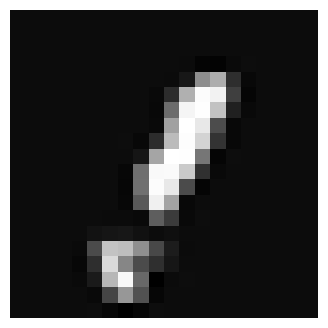

In [9]:
import matplotlib.pyplot as plt

model.eval()
random_idx = torch.randint(len(x_train_tensor), (1,)).item()

x, y = x_train_tensor[random_idx], y_train_tensor[random_idx]

with torch.no_grad():
    x = x.to(device)
    x = x.view(-1, 1, 20, 20)
    pred = model(x)
    predicted, actual = pred[0].argmax(0), y
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

x_image = x.cpu().numpy().squeeze()
x_image = x_image.reshape(20, 20)
plt.figure(figsize=(4, 4))
plt.imshow(x_image.transpose(), cmap='gray')
plt.axis('off')
plt.show()